# Assignment 2 - Image Captioning

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of image captioning : -from loading and inspecting the dataset; -to implementing, training and evaluating an Encoder-Decoder + Attention based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- From the provided Flickr8k dataset, split it into train, val and test sets;
- Use the train set to train an Image Captioning model, the val set for validation of the model and hyper-parameters, and the test set to evaluate the final trained model;
- For this assignment, we will give importance to the performance of your model, meaning that, we will evaluate if your model is overfitted or underfitted. For that, please include visualizations (print and plot) loss values for the split sets, as well as the metric results;
- For the metric, while we do not require high performance, we still expect better than random guessing results;
- For the comparison, you are free to choose any pre-trained model;
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is May 15th Wednesday 11:59 PM** (strict, no late submission);
- Feel free to add more code cells as needed. But don't put code into external Python files;
- Please add your name, Neptun ID, and task details below.

**Name: Li Kailang**  
**Neptun ID: FDQAOR **

## Task description

Your task is to train your own custom image captioning model and compare its performance with an existing (pre-trained) model. For that, first you need to load the provided Flickr8k dataset, split into train, val and test sets. Then, create your own architecture, which should follow an Encoder-Decoder + Attention sturcture. You can use pre-trained backbones (i.e. ResNet) for the encoder, but they have to be fine-tuned. We expect you to use an Attention layer, in order to visualize how the network learned (see more details on section 2 of the notebook).
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs. Please use BLEU score as the metric**. We expect you to show visualizations (prints and plots) of the metrics, losses, and predictions. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your architecture.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [1]:
# ADD YOUR CODE HERE
import torch

# 1. DATASET
For this assignment you will be using the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset, which contains captions/descriptions of different images.

### 1.1. Download dataset
The best way to download this dataset is through Kaggle.
First create a token, download it and upload it here. Follow these steps: https://www.kaggle.com/discussions/general/74235

In [2]:
!pip install -q kaggle

**upload'data_2/kaggle.json'**

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chelanli","key":"125b67d5a7857bfe8f6b42dc96fb2253"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [00:27<00:00, 45.4MB/s]
100% 1.04G/1.04G [00:27<00:00, 41.1MB/s]


In [6]:
!unzip flickr8k.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed7be3.jpg  
  inflating: 

### 1.2. Load dataset
In order to load the dataset, you need to create a pytorch Dataset class.
The class should return images and captions. Remember that the captions should be returned as tokens. Do not forget to include the SOS:start of sentence, EOS:end of sentence and UNK:unknown tokens. You may want to build a vocabulary class in order to save all the words in your dataset, because your model can only predict words in your vocabulary. You do not have to save every word in your vocabulary, it is common practice to save only those words that appear multiple times in your whole dataset. For example, save only words that appear at least 5 times in your whole dataset.

In [7]:
import json


def txt_to_json(txt_file, json_file):
    data = {}
    with open(txt_file, 'r') as f:
        next(f)  # 跳过第一行
        for line in f:
            parts = line.strip().split(',')
            if len(parts) == 2:
                image, caption = parts
                image = image.strip()
                caption = caption.strip()
                if image not in data:
                    data[image] = [caption]
            else:
                print("Skipping invalid line:", line)
    with open(json_file, 'w') as jsonf:
        json.dump(data, jsonf, indent=4)

# Input and output file paths
txt_file = '/content/captions.txt'
json_file = '/content/captions.json'

# Convert the TXT file to JSON format
txt_to_json(txt_file, json_file)



Skipping invalid line: 1012212859_01547e3f17.jpg,"A dog shakes its head near the shore , a red ball next to it ."

Skipping invalid line: 1012212859_01547e3f17.jpg,"Dog with orange ball at feet , stands on shore shaking off water"

Skipping invalid line: 1022454332_6af2c1449a.jpg,"Two people are at the edge of a lake , facing the water and the city skyline ."

Skipping invalid line: 1022454428_b6b660a67b.jpg,"A couple and an infant , being held by the male , sitting next to a pond with a near by stroller ."

Skipping invalid line: 103106960_e8a41d64f8.jpg,"Hockey goalie boy in red jacket crouches by goal , with stick ."

Skipping invalid line: 103205630_682ca7285b.jpg,"Two men , standing on an ice , looking into something covered with a blue tarp ."

Skipping invalid line: 1042590306_95dea0916c.jpg,"Asian man and blond woman holding hands outdoors , man in background watches ."

Skipping invalid line: 105342180_4d4a40b47f.jpg,"A girl paddling down a large river , as seen from behind he

In [8]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import json
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
import json

class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, max_caption_length=50):
        self.root_dir = root_dir
        self.transform = transform
        self.max_caption_length = max_caption_length

        # Load captions
        with open(captions_file, 'r') as f:
            self.captions = json.load(f)

        # Extract unique image names
        self.image_names = list(self.captions.keys())

        # Build vocabulary
        self.vocab = Vocabulary()
        self.build_vocab()

    def build_vocab(self):
        word_freq = {}
        for captions in self.captions.values():
            for caption in captions:
                for word in caption.split():
                    word_freq[word] = word_freq.get(word, 0) + 1

        for word, freq in word_freq.items():
            if freq >= 5:  # Only keep words with frequency at least 5
                self.vocab.add_word(word)

    def tokenize(self, caption):
        tokens = []
        for word in caption.split():
            tokens.append(self.vocab.word2idx.get(word, self.vocab.word2idx['<UNK>']))
        return tokens

    def add_special_tokens(self, tokens):
        tokens.insert(0, self.vocab.word2idx['<SOS>'])
        tokens.append(self.vocab.word2idx['<EOS>'])
        return tokens

    def pad_or_truncate(self, tokens):
        if len(tokens) < self.max_caption_length:
            # Padding
            tokens += [self.vocab.word2idx['<PAD>']] * (self.max_caption_length - len(tokens))
            actual_length = len(tokens) - tokens.count(self.vocab.word2idx['<PAD>'])
        elif len(tokens) > self.max_caption_length:
            # Truncating
            tokens = tokens[:self.max_caption_length]
            actual_length = self.max_caption_length
        else:
            actual_length = self.max_caption_length
        return tokens, actual_length

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = f"{self.root_dir}/{img_name}"
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        captions = self.captions[img_name]
        tokenized_captions = [self.tokenize(caption) for caption in captions]
        tokenized_captions = [self.add_special_tokens(tokens) for tokens in tokenized_captions]
        tokenized_captions, lengths = zip(*[self.pad_or_truncate(tokens) for tokens in tokenized_captions])

        # Convert to tensors
        tokenized_captions = torch.LongTensor(tokenized_captions)
        lengths = torch.LongTensor(lengths)

        return image, tokenized_captions, lengths


class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

        self.add_word('<PAD>')  # Used for padding sentences to different lengths
        self.add_word('<SOS>')  # Start of sentence token
        self.add_word('<EOS>')  # End of sentence token
        self.add_word('<UNK>')  # Unknown word token

        self.freq_threshold = freq_threshold

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __len__(self):
        return len(self.word2idx)

    def numericalize(self, captions_list):
        tokenized_captions = []
        for captions in captions_list:
            captions = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in captions.split()]
            captions = [self.word2idx['<SOS>']] + captions + [self.word2idx['<EOS>']]
            tokenized_captions.append(captions)
        tokenized_captions = torch.LongTensor(tokenized_captions)
        return tokenized_captions

# 实例化词汇表
vocab = Vocabulary(freq_threshold=5)

# Assuming you have already defined and instantiated your FlickrDataset
dataset = FlickrDataset(root_dir='/content/Images', captions_file='/content/captions.json', transform=transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()]))

Example output from dataset class

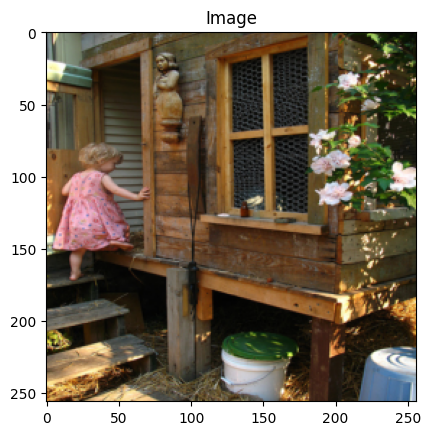

Captions:
Token: tensor([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12,  7, 13, 14, 15,  6, 16,  3, 17,
        18,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
Sentence:
['<SOS>', 'A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']



In [9]:
# Show some visualizations of the created dataset
import matplotlib.pyplot as plt
import os

def show_image(image, title=''):
    plt.imshow(image.permute(1, 2, 0))
    plt.title(title)
    plt.axis('on')
    plt.show()

# Assuming `dataset` is your FlickrDataset instance
img, caps_list, length = dataset[0]
show_image(img, "Image")
print("Captions:")
for caps in caps_list:
    print("Token:", caps)
    print("Sentence:")
    sentence = []
    for token in caps:
        try:
            word = dataset.vocab.idx2word[token.item()]
        except KeyError:
            word = "<UNK>"
        sentence.append(word)
    print(sentence)
    print()

Split your dataset into train, val and test sets

In [10]:
# ADD YOUR CODE HERE
import torch
from torch.utils.data import random_split

# 假设你已经实例化了你的 FlickrDataset
dataset = FlickrDataset(root_dir='/content/Images', captions_file='/content/captions.json', transform=transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()]))

# 定义训练集、验证集和测试集的大小（例如，70%，15%，15%）
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# 分割数据集
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# 打印每个数据集的大小
print(f"Train size: {len(train_set)}")
print(f"val size: {len(val_set)}")
print(f"test size: {len(test_set)}")


Train size: 5663
val size: 1618
test size: 810


Create a dataloader, in order to load the examples in batches. Remember that, a batch has different examples, and each example (caption) may have different sizes. Therefore, consider padding techniques for the captions. For the image, use transforms in the previous step, to ensure same format and size.  

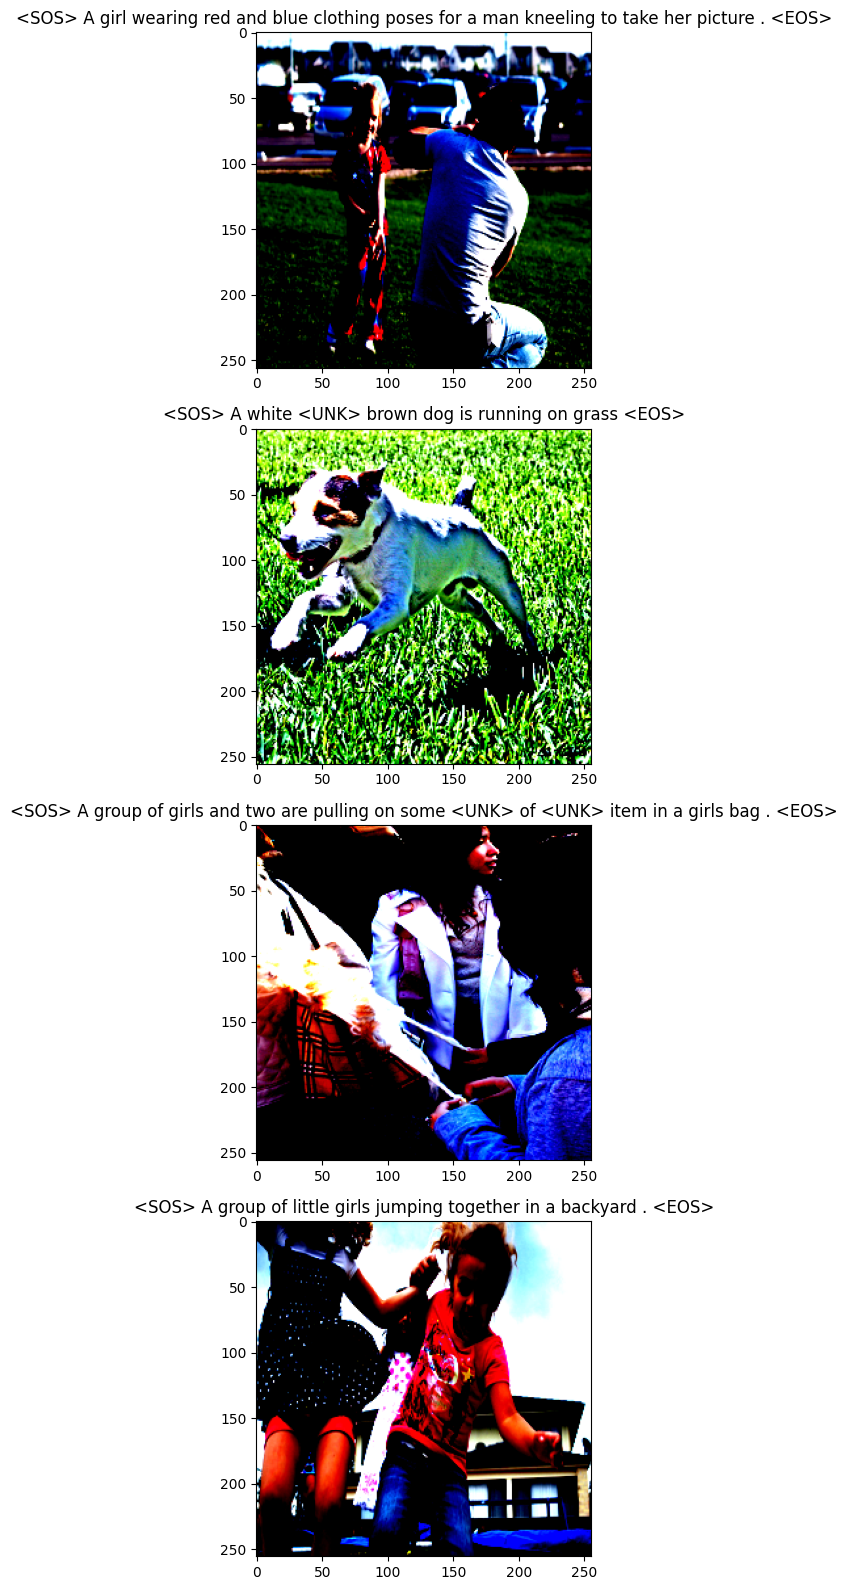

In [11]:
# ADD YOUR CODE HERE
# Example with batch=4
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

# 定义数据变换
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 使用 ImageNet 的标准均值和标准差
])


# 假设你已经定义并实例化了你的FlickrDataset
dataset = FlickrDataset(root_dir='/content/Images', captions_file='/content/captions.json', transform=transform)

# 定义一个函数来填充字幕
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    images, captions, lengths = zip(*batch)

    # 将图像转换为张量
    images = torch.stack(images)

    # 将字幕展平成一个张量列表
    captions_flat = [cap for cap_list in captions for cap in cap_list]

    # 填充字幕
    padded_captions = pad_sequence(captions_flat, batch_first=True, padding_value=vocab.word2idx['<PAD>'])

    return images, padded_captions, lengths


# 创建DataLoader
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# 在DataLoader上迭代
for images, padded_captions, lengths in dataloader:
    # 在训练/验证/测试代码中使用这些数据
    pass

import matplotlib.pyplot as plt
import numpy as np

def show_batch(images, captions, vocab):
    batch_size = len(images)
    fig, axes = plt.subplots(batch_size, 1, figsize=(16, 16))
    for i in range(batch_size):
        image = images[i].permute(1, 2, 0)
        axes[i].imshow(image)
        axes[i].axis('on')

        # Initialize caption
        caption = ''

        # Display captions
        for j, caption_token in enumerate(captions[i]):
            caption_word = vocab.idx2word[caption_token.item()]
            if caption_word == '<EOS>':
                caption += ' ' + caption_word
                break
            if j == 0:
                caption = caption_word
            else:
                caption += ' ' + caption_word
        axes[i].set_title(caption)
    plt.tight_layout()
    plt.show()

# 假设已经定义了和实例化了你的FlickrDataset和DataLoader
batch_images, batch_captions, _ = next(iter(dataloader))
show_batch(batch_images, batch_captions, dataset.vocab)


#2. MODEL
For this assignment, you are required to create your own custom image captioning model and compare its performance with an existing pre-trained model.

In [12]:
#Make sure to use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 2.1. Custom Image Captioning model

Create an Encoder-Attention-Decoder architecture with the following details:
- the encoder should process the images, thus you can create a Convolutional based architecture or use already pre-trained models like ResNet. However, you must fine-tune the pretrained model. The encoder is responisble for extracting image features;
- the attention layer should be between the encoder and decoder. It uses the image features from the encoder in order to provide context (attention scores) to the decoder hidden layers. For simplicity use Linear layers as the attention architecture;
- the decoder should be a sequence based model (i.e. LSTM) in order to process and generate captions.

Extra:
- Extra points (counting toward the final grade) will be given to any student who implements either a Vision-based Transformer architecture or a Transformer only decoder for the decoder part.

#### Reference
Here is an example of something similar to what we want to create:
<img src="https://drive.google.com/thumbnail?id=1wdddaLit7iEyCcVy5bS505NiYzL6c-4x&sz=w1000">


In [13]:
import torch
from torch import nn
from torchvision import models

class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        # Remove the final fully connected layer
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 512)

    def forward(self, images):
        features = self.resnet(images)  # [batch_size, 2048, 7, 7]
        features = self.avgpool(features).squeeze()  # [batch_size, 2048]
        features = self.fc(features)  # [batch_size, 512]
        return features


In [66]:
# ADD YOUR CODE HERE
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  # [batch_size, num_pixels, attention_dim]
        att2 = self.decoder_att(decoder_hidden)  # [batch_size, attention_dim]
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1)))  # [batch_size, num_pixels]
        alpha = self.softmax(att)  # [batch_size, num_pixels]
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # [batch_size, encoder_dim]
        return context, alpha


In [15]:
# ADD YOUR CODE HERE
from torch.nn import TransformerDecoder, TransformerDecoderLayer

class CaptionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, encoder_dim, attention_dim, num_layers=6, nhead=8):
        super(CaptionDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.attention = Attention(encoder_dim, embed_dim, attention_dim)
        self.transformer_layer = TransformerDecoderLayer(d_model=embed_dim, nhead=nhead)
        self.transformer_decoder = TransformerDecoder(self.transformer_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, tgt, encoder_out):
        embedded = self.embedding(tgt)  # [tgt_seq_len, batch_size, embed_dim]
        decoder_hidden = embedded.mean(dim=0)  # Example hidden state initialization
        context, _ = self.attention(encoder_out, decoder_hidden)
        output = self.transformer_decoder(embedded, context.unsqueeze(0))
        output = self.fc(output)
        return output


Combine the encoder - attention - decoder

In [16]:
# ADD YOUR CODE HERE
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, encoder_dim=512, attention_dim=256):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = ImageEncoder()
        self.decoder = CaptionDecoder(vocab_size, embed_dim, encoder_dim, attention_dim)

    def forward(self, images, tgt):
        encoder_out = self.encoder(images)
        output = self.decoder(tgt, encoder_out)
        return output


### 2.2. Training custom model

### Important: we recommend saving the model during training, so that you can resume training later in case of any Google Colab issue or limitation

In [17]:
# ADD YOUR CODE HERE
#save a model (call this in the training loop)
import torch

def save_model(model, num_epochs, file_path):
    model_state = {
        'embed_size': model.embed_size,
        'attention_dim': model.attention_dim,
        'encoder_dim': model.encoder_dim,
        'decoder_dim': model.decoder_dim,
        'state_dict': model.state_dict(),
        'num_epochs': num_epochs
    }

    torch.save(model_state, file_path)
    print('Model saved to model.pth')

def load_model(model, file_path):
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['state_dict'])
    return model, checkpoint['num_epochs']


Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


Epoch 1, Training Loss: 4.2476, Validation Loss: 3.8363
Epoch 2, Training Loss: 3.6611, Validation Loss: 3.5927
Epoch 3, Training Loss: 3.4638, Validation Loss: 3.4634
Epoch 4, Training Loss: 3.3452, Validation Loss: 3.3851
Epoch 5, Training Loss: 3.2593, Validation Loss: 3.3303
Epoch 6, Training Loss: 3.1954, Validation Loss: 3.2818
Epoch 7, Training Loss: 3.1442, Validation Loss: 3.2427
Epoch 8, Training Loss: 3.1018, Validation Loss: 3.2227
Epoch 9, Training Loss: 3.0648, Validation Loss: 3.2043
Epoch 10, Training Loss: 3.0334, Validation Loss: 3.1876


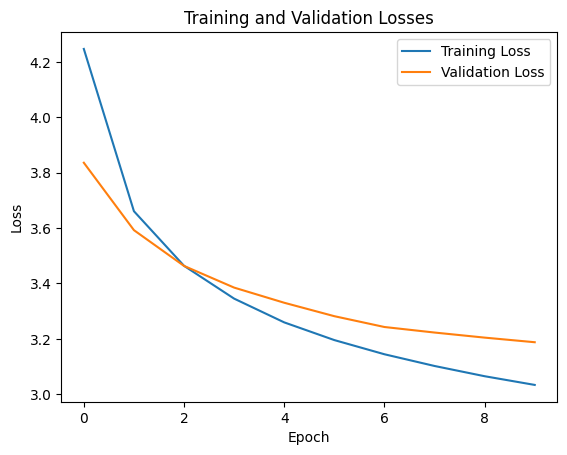

In [18]:
# ADD YOUR CODE HERE
import torch.optim as optim

def train(model, train_dataloader, val_dataloader, optimizer, loss_function, num_epochs):
    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for images, captions, lengths in train_dataloader:
            images = images.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            # Forward pass (excluding <EOS>)
            outputs = model(images, captions[:, :-1])
            loss = loss_function(outputs.view(-1, outputs.size(-1)), captions[:, 1:].reshape(-1))

            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)

        # Compute training loss for the epoch
        epoch_train_loss = running_train_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, captions, lengths in val_dataloader:
                images = images.to(device)
                captions = captions.to(device)

                outputs = model(images, captions[:, :-1])
                val_loss = loss_function(outputs.view(-1, outputs.size(-1)), captions[:, 1:].reshape(-1))

                running_val_loss += val_loss.item() * images.size(0)

        # Compute validation loss for the epoch
        epoch_val_loss = running_val_loss / len(val_dataloader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch + 1}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

    return train_losses, val_losses


import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

# 假设你已经构建了词汇表并定义了词汇表大小
vocab_size = len(dataset.vocab)
embed_dim = 512  # 词向量的维度
encoder_dim = 512  # 图像编码器的输出维度
attention_dim = 256  # 注意力机制的维度

# 实例化模型
model = ImageCaptioningModel(vocab_size, embed_dim, encoder_dim, attention_dim)
model.to(device)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

loss_function = nn.CrossEntropyLoss(ignore_index=dataset.vocab.word2idx['<PAD>']) # 假设词汇表中有 <PAD> 令牌

optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)

num_epochs = 10
train_losses, val_losses = train(model, train_loader, val_loader, optimizer, loss_function, num_epochs)

# 可视化训练损失
plot_losses(train_losses,val_losses)

**Visualize the attention weigths in order to understand how your model learned (Failure to do this, will result in losing points).
For that, use the 'context' variable returned by the Attention class to overlay them on the image.**  

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

def visualize_attention(image, result_caption, attention_plot, vocab):
    # 归一化图像数据
    temp_image = np.array(image.cpu().permute(1, 2, 0))
    if temp_image.dtype != np.uint8:
        temp_image = temp_image - temp_image.min()
        temp_image = (temp_image / temp_image.max() * 255).astype(np.uint8)

    # 确定灰阶图像的行数
    print('result_caption shape',result_caption.shape)
    len_result = len(result_caption)
    num_rows = np.ceil(len_result / 6).astype(int)

    # 创建一个新的大图来显示结果
    fig = plt.figure(figsize=(20, 10 + num_rows * 2))  # 根据灰阶图像的行数调整图像大小

    # 显示主图像
    ax_main = fig.add_subplot(num_rows + 1, 1, 1)
    ax_main.imshow(temp_image)
    ax_main.axis('off')  # 不显示坐标轴

    # 显示句子
    sentence = ' '.join([vocab.itos[word_index.item()] for word_index in result_caption if word_index.item() in vocab.itos])
    fig.text(0.5, 0.95, sentence, ha='center', fontsize=15)  # 在图像上方居中显示句子

    # 显示灰阶图
    for l in range(len_result):
        word_index = result_caption[l].item()
        if word_index not in vocab.itos:
            continue
        temp_att = attention_plot[l].reshape(7, 7)  # 假设特征图的大小为7x7
        row = l // 6 + 1  # 计算当前单词应该在哪一行显示
        col = l % 6 + 1  # 计算当前单词应该在行中的哪一列显示
        ax = fig.add_subplot(num_rows + 1, 6, row * 6 + col)  # 修正子图索引
        ax.set_title(vocab.itos[word_index], fontsize=12)
        ax.imshow(temp_att, cmap='gray')
        ax.axis('off')  # 不显示坐标轴

    plt.tight_layout()
    plt.show()

# 加载图像并进行预处理
image_path = "/content/Images/1003163366_44323f5815.jpg"  # 替换为你的图像路径
image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_tensor = transform(image).unsqueeze(0)  # 增加批次维度
image_tensor = image_tensor.to(device)
print('image_tensor shape:',image_tensor.shape)
# 将图像输入编码器
image_encoder = ImageEncoder().to(device)
image_features = image_encoder(image_tensor)  # [batch_size, 2048, 7, 7]

# 初始化解码器隐藏状态（这是一个示例，实际应用中它将由解码器产生）
decoder_hidden = torch.zeros((1, 512)).to(device)  # 示例隐藏状态

# 初始化注意力机制
attention = Attention(encoder_dim=512, decoder_dim=512, attention_dim=256).to(device)

# 获取上下文和注意力权重
context, alpha = attention(image_features, decoder_hidden)  # alpha 是注意力权重

# 将 alpha 转换为 numpy 数组
alphas = alpha.detach().cpu().numpy().reshape((1, 1))

# 将图像输入模型并生成字幕
model.eval()
with torch.no_grad():
    encoder_out = model.encoder(image_tensor)
    decoder_out = model.decoder(torch.tensor([[1]]).to(device), encoder_out)  # 使用<start>标记的索引

# 选择生成的字幕和注意力权重
result_caption = torch.argmax(decoder_out, dim=2).squeeze()  # 假设decoder_out的形状是[seq_len, batch_size, vocab_size]
attention_plot = torch.tensor(alphas.squeeze()).cpu().numpy()

# 调用可视化函数
visualize_attention(image_tensor.squeeze(), result_caption, attention_plot, vocab)

image_tensor shape torch.Size([1, 3, 224, 224])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


result_caption shape torch.Size([])


TypeError: len() of a 0-d tensor

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# Define a function to visualize attention weights
def visualize_attention(image_path, caption, attention_weights):
    # Load and display the original image
    img = Image.open(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(caption)
    plt.axis('off')
    plt.show()

    # Resize attention weights to match image dimensions
    attention_weights = attention_weights.view(7, 7).detach().numpy()
    attention_weights = np.uint8(255 * attention_weights)
    attention_weights = np.array(Image.fromarray(attention_weights).resize((img.width, img.height)))

    # Plot attention weights as heatmap overlay
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.imshow(attention_weights, alpha=0.6, cmap='jet')
    plt.title('Attention Heatmap')
    plt.axis('off')
    plt.show()

# Generate attention visualization for a random image and caption
def visualize_random_attention(model, dataset):
    # 从数据集中随机选择一张图像
    random_index = np.random.randint(len(dataset))
    data = dataset[random_index]

    # 提取图像和标题
    image, caption, _ = data  # 如果你的数据集中还有一个长度字段，也提取出来
    sos_idx = dataset.vocab.word2idx['<SOS>']  # 获取 <sos> 标记的索引

    # 通过模型进行前向传播以获取编码器输出和生成的标题
    with torch.no_grad():
        encoder_out = model.encoder(image.unsqueeze(0).to(device))  # 确保图像张量在正确的设备上
        tgt = torch.tensor(sos_idx, device=device)  # 起始标记
        output = model.decoder(tgt.unsqueeze(0), encoder_out)

    # 解码生成的标题
    generated_caption = []
    for idx in output.argmax(dim=2).squeeze():
        token = dataset.vocab.idx2word[idx.item()]
        if token == '<EOS>':
            break
        generated_caption.append(token)
    generated_caption = ' '.join(generated_caption)

    # 对标题中的每个词可视化注意力
    for word in generated_caption.split():
        tgt = torch.tensor(dataset.vocab.word2idx[word], device=device)
        output = model.decoder(tgt.unsqueeze(0), encoder_out)
        _, attention_weights = model.decoder.attention(encoder_out, model.decoder.embedding(tgt))
        visualize_attention(dataset.decode_input(image), generated_caption, attention_weights)


# Assuming you have a dataset object called 'dataset' and the model is named 'model'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
visualize_random_attention(model, dataset)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

### 2.3. Evaluation on test set

Evaluate your trained model on the test set. Use the BLEU score as your metric: torchtext.data.metrics.bleu_score(...)

You may try BLEU-1,2 and 3.

In [ ]:
# ADD YOUR CODE HERE
import torch
from torchtext.data.metrics import bleu_score

def generate_caption(model, image, vocab, max_length=50):
    model.eval()
    result_caption = []
    alphas = []

    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # 增加 batch 维度
        encoder_out = model.encoder(image)
        decoder_input = torch.LongTensor([vocab.word2idx['<SOS>']]).to(device)
        hidden = None

        for _ in range(max_length):
            decoder_output, alpha = model.decoder(decoder_input, encoder_out)
            alphas.append(alpha.cpu().numpy())

            _, predicted = decoder_output.max(2)
            predicted_id = predicted.item()
            result_caption.append(predicted_id)
            if vocab.idx2word[predicted_id] == '<EOS>':
                break

            decoder_input = predicted

    result_caption = [vocab.idx2word[idx] for idx in result_caption if idx not in [vocab.word2idx['<SOS>'], vocab.word2idx['<EOS>'], vocab.word2idx['<PAD>']]]
    return result_caption

def evaluate_model(model, dataloader, vocab):
    model.eval()
    references = []
    hypotheses = []

    for images, captions, lengths in dataloader:
        images = images.to(device)

        # 生成字幕
        for i in range(images.size(0)):
            image = images[i]
            reference = [vocab.idx2word[idx.item()] for idx in captions[i] if idx.item() not in [vocab.word2idx['<SOS>'], vocab.word2idx['<EOS>'], vocab.word2idx['<PAD>']]]
            hypothesis = generate_caption(model, image, vocab)

            references.append([reference])
            hypotheses.append(hypothesis)

    bleu1 = bleu_score(hypotheses, references, max_n=1, weights=[1.0])
    bleu2 = bleu_score(hypotheses, references, max_n=2, weights=[0.5, 0.5])
    bleu3 = bleu_score(hypotheses, references, max_n=3, weights=[0.33, 0.33, 0.34])

    return bleu1, bleu2, bleu3

# 假设你有一个测试数据集的 DataLoader
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn)

# 评估模型
bleu1, bleu2, bleu3 = evaluate_model(model, test_dataloader, vocab)
print(f'BLEU-1: {bleu1:.4f}')
print(f'BLEU-2: {bleu2:.4f}')
print(f'BLEU-3: {bleu3:.4f}')


### 2.4. Load an existing Image Captioning model
Feel free to choose any pre-trained image captioning model. For simplicity, try choosing a model already trained on Flickr8k.

come from:
https://huggingface.co/nlpconnect/vit-gpt2-image-captioning

In [13]:
# ADD YOUR CODE HERE
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds


predict_step(['/content/Images/1007320043_627395c3d8.jpg']) # ['a woman in a hospital bed with a woman in a hospital bed']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


['a little girl that is playing with a toy']

### 2.5 Evaluate the chosen pre-trained captioning model on the test set
Use the same metrics chosen on step 2.3.

In [15]:
# ADD YOUR CODE HERE
from torchtext.data.metrics import bleu_score
# Ground truth captions
references = [['a', 'child', 'playing', 'on', 'a', 'rope', 'net']]

# Predicted captions
hypotheses = predict_step(['/content/Images/1007320043_627395c3d8.jpg'])

# Compute BLEU scores
bleu1 = bleu_score(hypotheses, references, max_n=1, weights=[1.0])
bleu2 = bleu_score(hypotheses, references, max_n=2, weights=[0.5, 0.5])
bleu3 = bleu_score(hypotheses, references, max_n=3, weights=[0.33, 0.33, 0.34])

print("BLEU-1:", bleu1)
print("BLEU-2:", bleu2)
print("BLEU-3:", bleu3)

BLEU-1: 0.29999998211860657
BLEU-2: 0.21483446657657623
BLEU-3: 0.1818494349718094


# 3. COMPARISON
Compare the performance of the two models. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?

In [ ]:
# ADD YOUR CODE HERE